In [1]:
!pip install fastai --upgrade
!pip install timm wwf

Requirement already up-to-date: fastai in /usr/local/lib/python3.7/dist-packages (2.2.7)


In [2]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-03-01 14:54:44--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-03-01 14:54:44--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5e83904046ca90e3dfc14f44e6.dl.dropboxusercontent.com/cd/0/get/BJ12tPAxFCJ53HFqx_l3uKgbSHBi33kf_7Wx_XnPWpi6qGPYHUPiWOZW8-7gds4tKVDVIMABV8jaZtA1G8nWnhNznzn3U99eLZyTdubaSDKvNKZk0mYDVEMutxC6_M9jWp0/file?dl=1# [following]
--2021-03-01 14:54:45--  https://uc5e83904046ca90e3dfc14f44e6.dl.dropboxusercontent.com/cd/0/get/BJ12tPAxFCJ53HFqx_l3uKgbSHBi33kf_7Wx_XnPWpi6qGPYHUPiWOZW8-7gds4tKVDVIMABV8jaZtA1G8nWnhNznzn3U99eLZyTdubaSDKvNKZk0mYDVEMut

In [3]:
!unzip erm.zip

Archive:  erm.zip
replace dataset/test/no/anonymized_1421704.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_4

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='hrnet_w64'),
]

In [9]:
import timm
timm.list_models('*hrnet_w64*')

['hrnet_w64']

In [10]:
learn = Learner(dls512, timm.models.hrnet.hrnet_w64(num_classes=2),cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

SuggestedLRs(lr_min=0.13182567358016967, lr_steep=1.0964782238006592)

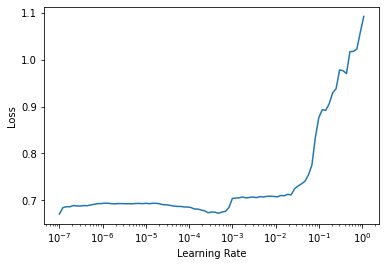

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.688763,0.685456,0.562691,0.534632,0.776730,01:31


Better model found at epoch 0 with valid_loss value: 0.6854562163352966.


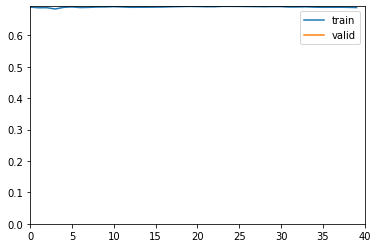

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.664955,0.679672,0.562691,0.536530,0.738994,01:30
1,0.659079,0.672889,0.585627,0.554273,0.754717,01:30
2,0.646592,0.661198,0.607034,0.571429,0.767296,01:30
3,0.623604,0.644013,0.619266,0.584767,0.748428,01:30
4,0.588827,0.618367,0.652905,0.617571,0.751572,01:29
5,0.538099,0.598455,0.681957,0.670807,0.679245,01:30
6,0.497062,0.583061,0.698777,0.690852,0.688679,01:30
7,0.448518,0.603646,0.698777,0.676385,0.729560,01:30
8,0.406205,0.617596,0.694190,0.661202,0.761006,01:30
9,0.356696,0.647694,0.692661,0.681115,0.691824,01:30


Better model found at epoch 0 with valid_loss value: 0.679672360420227.


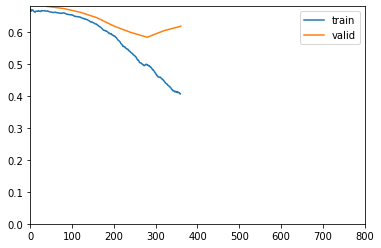

Better model found at epoch 1 with valid_loss value: 0.6728892922401428.
Better model found at epoch 2 with valid_loss value: 0.6611984968185425.
Better model found at epoch 3 with valid_loss value: 0.6440127491950989.
Better model found at epoch 4 with valid_loss value: 0.6183665990829468.
Better model found at epoch 5 with valid_loss value: 0.5984547734260559.
Better model found at epoch 6 with valid_loss value: 0.5830614566802979.
No improvement since epoch 6: early stopping


In [12]:
learn.fine_tune(20,base_lr=1e-5)

In [13]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

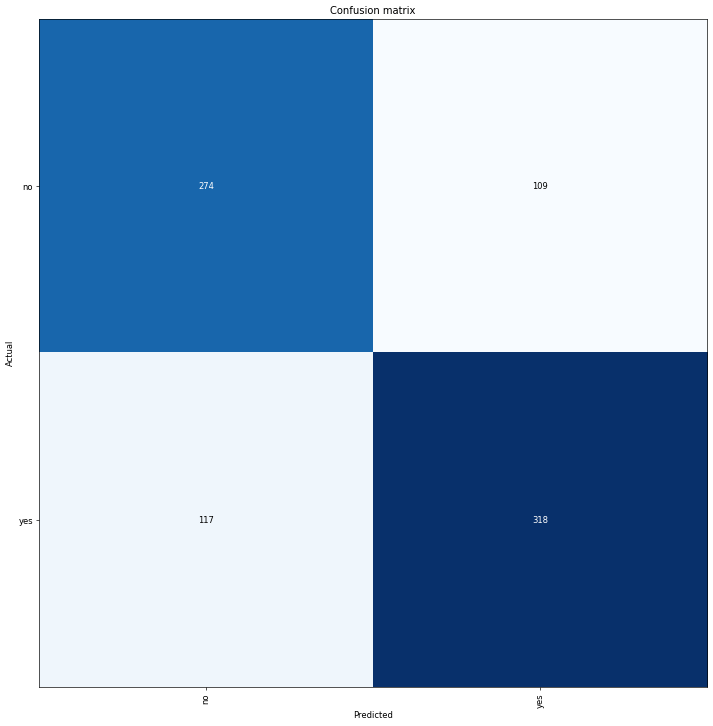

In [14]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [15]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7237163782119751.


(#4) [0.5541650056838989,0.7237163782119751,0.7447306791569087,0.7310344827586207]

In [16]:
learn.export(fname='hrnet64.pkl')